## Defense study - 1
This jupyter notebook creates plots to study the impact of upgrading/new stations near max charging


### 0. Analysis IDs to compare

In [141]:
# Define the set id for the analysis_ids that we want to compare
set_id  = (102, 110, 111, 112, 113, 114, 115 )

### 1. Package Installs

In [142]:
# python-dtenv to read the env variables
#!pip install python-dotenv

In [143]:
# Seaborn for plotting
#!pip install seaborn

In [144]:
#!pip install xarray

In [145]:
# Plotly for plotting 
#!pip install plotly

In [146]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import os
import psycopg2
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px
import xarray as xr
import plotly.data as pdata
from barchart3d import barchart3d

### 2. Environment Variables

In [147]:
# Load the environment variables
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [148]:
# Print this to see if the env variables are read now
os.getenv("COMPOSE_PROJECT_NAME")

'chargeval_dev'

### 3. Database connection

In [149]:
# Generic function to test the connection to the database
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(    
            host=os.getenv("MAIN_HOST"),
            database=os.getenv("MAIN_DB"),
            user=os.getenv("DBREAD_USER"),
            password=os.getenv("DBREAD_PWD"), 
            port = os.getenv("MAIN_PORT")
        )
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [150]:
# Make the test database connection
connect()

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 12.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',)
Database connection closed.


In [151]:
conn = psycopg2.connect(    
    host=os.getenv("MAIN_HOST"),
    database=os.getenv("MAIN_DB"),
    user=os.getenv("DBREAD_USER"),
    password=os.getenv("DBREAD_PWD"), 
    port = os.getenv("MAIN_PORT")
)

# create a cursor
cur = conn.cursor()

### 4. Database queries

In [152]:
cur.execute('select count(veh_id) from wa_bevs')
evs_in_wa = cur.fetchone()
evs_in_wa

(46727,)

In [153]:
sql_evs_in_sim = 'select count(veh_id), analysis_id from evtrip_scenarios where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_in_sim, (analysis_ids,))
evs_in_sim = pd.read_sql_query(sql=sql_evs_in_sim, con=conn, params=(set_id,))
evs_in_sim

,count,analysis_id
0,881,500
1,880,501
2,900,502
3,857,503
4,884,504
5,885,536
6,886,537
7,904,538
8,857,539
9,889,540


In [154]:
sql_evs_fin = 'select count(veh_id), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_fin, (analysis_ids,))
evs_fin = pd.read_sql_query(sql=sql_evs_fin, con=conn, params=(set_id,))
evs_fin

,count,analysis_id
0,888,550
1,885,552
2,852,539
3,853,554
4,878,541
5,903,556
6,874,500
7,899,502
8,902,561
9,881,546


In [155]:
sql_evs_str = 'select count(veh_id), analysis_id from ev_stranded where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_str, (analysis_ids,)) # Uncomment for debugging the query
evs_str = pd.read_sql_query(sql=sql_evs_str, con=conn, params=(set_id,))
evs_str

,count,analysis_id
0,3,550
1,4,552
2,5,539
3,6,554
4,7,541
5,5,556
6,7,500
7,1,502
8,6,561
9,7,546


In [156]:
sql_evs_str_loc = '''select stranded_lat, stranded_lng, est.analysis_id, coalesce(ne.count, 0) as nevse_count
from ev_stranded est
         left join (
    select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on est.analysis_id = ne.analysis_id
where est.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
ORDER BY nevse_count;'''
evs_str_loc = pd.read_sql_query(sql=sql_evs_str_loc, con=conn, params=(set_id,))
evs_str_loc.head()

,stranded_lat,stranded_lng,analysis_id,nevse_count
0,47.911286,-122.056103,503,0
1,47.650638,-122.523110,503,0
2,47.089110,-121.583242,503,0
3,46.664757,-123.808478,503,0
4,48.060992,-119.889099,500,0


In [157]:
sql_evmt = 'select sum(distance_travelled), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evmt, (analysis_ids,))
evmt = pd.read_sql_query(sql=sql_evmt, con=conn, params=(set_id,))
evmt

,sum,analysis_id
0,104236.0,550
1,104054.0,552
2,99363.0,539
3,99684.0,554
4,104827.0,541
5,109682.0,556
6,104113.0,500
7,104307.0,502
8,109590.0,561
9,105069.0,546


In [158]:
sql_cs = 'select count(cs_id), analysis_id from evse_charging_session where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_cs, (analysis_ids,))
cs = pd.read_sql_query(sql=sql_cs, con=conn, params=(set_id,))
cs

,count,analysis_id
0,631,550
1,594,552
2,573,539
3,577,554
4,608,541
5,690,556
6,584,500
7,575,502
8,690,561
9,610,546


In [159]:
sql_ws = 'select count(wait_id), analysis_id from evse_evs_waiting where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_ws, (analysis_ids,))
ws = pd.read_sql_query(sql=sql_ws, con=conn, params=(set_id,))
ws

,count,analysis_id
0,114,550
1,78,552
2,36,539
3,87,554
4,47,541
5,110,556
6,124,500
7,100,502
8,104,561
9,96,546


In [160]:
# basecase_aid = 438
sql_evse_util = """SELECT epd.analysis_id,
       epd.simulation_ts::timestamp as datetime,
       sum(epd.power_val)           as total_power,
       coalesce(ne.count, 0)               as nevse_count
FROM evse_power_draw epd
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on epd.analysis_id = ne.analysis_id
WHERE epd.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
GROUP BY epd.simulation_ts, epd.analysis_id, nevse_count
ORDER BY nevse_count, epd.simulation_ts::timestamp;"""
# cur.mogrify(sql_evse_util, (analysis_ids,))
evse_util = pd.read_sql_query(sql=sql_evse_util, con=conn, params=(set_id,))
evse_util

,analysis_id,datetime,total_power,nevse_count
0,503,2019-07-01 06:00:27,0,0
1,501,2019-07-01 06:00:45,0,0
2,500,2019-07-01 06:00:56,0,0
3,504,2019-07-01 06:01:22,0,0
4,503,2019-07-01 06:01:27,0,0
...,...,...,...,...
37821,555,2019-07-02 05:04:22,0,5
37822,555,2019-07-02 05:05:22,0,5
37823,555,2019-07-02 05:06:22,0,5
37824,555,2019-07-02 05:07:22,0,5


In [161]:
sql_seeds = """select param_value as seed, analysis_id from analysis_params where analysis_id IN (select analysis_id from analysis_record where set_id = 102 order by analysis_id) and param_id = 1;"""
seeds = pd.read_sql_query(sql=sql_seeds, con=conn)['seed'].tolist()
# a_ids = a_ids[:-1]
seeds

['410', '600', '210', '577', '103']

In [162]:
sql_aids = """select analysis_id from analysis_record where set_id IN %s order by analysis_id"""
a_ids = pd.read_sql_query(sql=sql_aids, con=conn, params=(set_id,))['analysis_id'].tolist()
# a_ids = a_ids[:-1]
a_ids

[500,
 501,
 502,
 503,
 504,
 536,
 537,
 538,
 539,
 540,
 541,
 542,
 543,
 544,
 545,
 546,
 547,
 548,
 549,
 550,
 551,
 552,
 553,
 554,
 555,
 556,
 557,
 558,
 559,
 560,
 561,
 562,
 563,
 564,
 565]

In [191]:
basecase_aid

484

In [163]:
# basecase_aid = 438
sql_count_stats = """select count(ets.veh_id) as sim_count,
       ets.analysis_id,
       coalesce(ne.count, 0) as nevse_count,
       ef.fin_count,
       ef.evmt,
       es.str_count,
       ecs.cs_count,
       ew.wait_count
from evtrip_scenarios ets
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on ets.analysis_id = ne.analysis_id
         join (select count(veh_id) as fin_count, sum(distance_travelled) as evmt, analysis_id
               from ev_finished
               group by analysis_id) as ef
              on ets.analysis_id = ef.analysis_id
         join (select count(veh_id) as str_count, analysis_id from ev_stranded group by analysis_id) as es
              on ets.analysis_id = es.analysis_id
         join (select count(cs_id) as cs_count, analysis_id from evse_charging_session group by analysis_id) as ecs
              on ets.analysis_id = ecs.analysis_id
join (select count(wait_id) as wait_count, analysis_id from evse_evs_waiting group by analysis_id) as ew
              on ets.analysis_id = ew.analysis_id
where ets.analysis_id IN (select analysis_id from analysis_record where set_id IN %s UNION (select %s as analysis_id))
group by ets.analysis_id, nevse_count, ef.fin_count, es.str_count, ef.evmt, ecs.cs_count, ew.wait_count
order by ets.analysis_id desc
;"""
count_stats = pd.read_sql_query(sql=sql_count_stats, con=conn, params=(set_id,basecase_aid))
#count_stats.sort_values(by=['analysis_id'], inplace=True)
count_stats

,sim_count,analysis_id,nevse_count,fin_count,evmt,str_count,cs_count,wait_count
0,904,565,5,900,106630.0,4,667,118
1,875,564,5,871,102941.0,4,632,72
2,920,563,5,919,108087.0,1,632,90
3,898,562,5,895,106337.0,3,624,68
4,908,561,5,902,109590.0,6,690,104
5,904,560,5,900,106617.0,4,674,112
6,875,559,5,871,102939.0,4,622,64
7,920,558,5,916,107775.0,4,630,86
8,898,557,5,895,106346.0,3,614,72
9,908,556,5,903,109682.0,5,690,110


In [164]:
# count_stats.dtypes
# count_stats = count_stats.sort_values(by=['nevse_count'])
# count_stats

In [165]:
sql_comp_stats = """select lai.action_tstamp_tx                                               as start_time,
       lau.aid,
       lau.action_tstamp_tx                                               as end_time_tripgen,
       las.action_tstamp_tx,
       '# EV: ' || es.ev_count as ev_count,
       coalesce(ne.count, 0) as nevse_count,
       ((DATE_PART('day', lau.action_tstamp_tx - lai.action_tstamp_tx) * 24 +
         DATE_PART('hour', lau.action_tstamp_tx - lai.action_tstamp_tx)) * 60 +
        DATE_PART('minute', lau.action_tstamp_tx - lai.action_tstamp_tx)) as time_taken_tripgen,
       ((DATE_PART('day', las.action_tstamp_tx - lau.action_tstamp_tx) * 24 +
         DATE_PART('hour', las.action_tstamp_tx - lau.action_tstamp_tx)) * 60 +
        DATE_PART('minute', las.action_tstamp_tx - lau.action_tstamp_tx)) as time_taken_eviabm
from audit.logged_actions lai
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'trips_generated') as lau
              on lau.aid = lai.row_data -> 'analysis_id'
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'solved') as las
              on las.aid = lai.row_data -> 'analysis_id'
         join (select count(veh_id) as ev_count, analysis_id from public.evtrip_scenarios group by analysis_id) as es
              on es.analysis_id = (lai.row_data -> 'analysis_id')::int
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on (lai.row_data -> 'analysis_id')::int = ne.analysis_id
where lai.action = 'I'
  and lai.row_data -> 'analysis_id' ~* (select string_agg(cast(analysis_id as text), '|') from analysis_record where set_id IN %s)
ORDER BY nevse_count
;"""
# data = '|'.join(map(str,set_id))
comp_stats = pd.read_sql_query(sql=sql_comp_stats, con=conn, params=(set_id,))
comp_stats

,start_time,aid,end_time_tripgen,action_tstamp_tx,ev_count,nevse_count,time_taken_tripgen,time_taken_eviabm
0,2021-04-14 22:36:37.484010+00:00,500,2021-04-14 22:50:22.202472+00:00,2021-04-15 02:40:23.903212+00:00,# EV: 881,0,13.0,230.0
1,2021-04-14 22:36:40.681573+00:00,501,2021-04-14 22:50:21.409969+00:00,2021-04-15 02:24:14.703710+00:00,# EV: 880,0,13.0,213.0
2,2021-04-14 22:36:43.845769+00:00,502,2021-04-14 22:51:19.139308+00:00,2021-04-15 02:32:15.450557+00:00,# EV: 900,0,14.0,220.0
3,2021-04-14 22:36:47.010014+00:00,503,2021-04-14 22:50:21.279622+00:00,2021-04-15 01:57:44.459085+00:00,# EV: 857,0,13.0,187.0
4,2021-04-14 22:36:50.224210+00:00,504,2021-04-14 22:51:47.288835+00:00,2021-04-15 02:19:22.113497+00:00,# EV: 884,0,14.0,207.0
5,2021-04-15 01:14:41.389541+00:00,536,2021-04-15 02:12:57.463089+00:00,2021-04-15 06:02:52.440982+00:00,# EV: 885,5,58.0,229.0
6,2021-04-15 01:14:45.331448+00:00,537,2021-04-15 02:09:27.747090+00:00,2021-04-15 05:26:38.149102+00:00,# EV: 886,5,54.0,197.0
7,2021-04-15 01:14:48.527325+00:00,538,2021-04-15 02:13:11.559090+00:00,2021-04-15 05:56:34.471506+00:00,# EV: 904,5,58.0,223.0
8,2021-04-15 01:14:51.725727+00:00,539,2021-04-15 02:15:20.673940+00:00,2021-04-15 05:52:13.038926+00:00,# EV: 857,5,60.0,216.0
9,2021-04-15 01:14:54.911861+00:00,540,2021-04-15 02:12:13.235095+00:00,2021-04-15 05:49:52.957366+00:00,# EV: 889,5,57.0,217.0


## Find charging stations with max charging sessions

In [166]:
basecase_aid = 484
sql_be_cs = """select count(cs_id) as count, analysis_id, evse_id, be.latitude, be.longitude
from evse_charging_session ecs
         left join built_evse be on
    'b' || cast(be.bevse_id as text) = ecs.evse_id
where ecs.analysis_id = 484
group by ecs.analysis_id, ecs.evse_id, be.latitude, be.longitude
order by count desc
limit 5;
"""
be_cs = pd.read_sql_query(sql=sql_be_cs, con=conn, params=(basecase_aid,))
be_cs.head()

,count,analysis_id,evse_id,latitude,longitude
0,58,484,b124683,48.095461,-122.186896
1,39,484,b145684,47.998233,-122.100638
2,37,484,b73433,47.420940,-121.411300
3,34,484,b167497,47.188833,-120.903139
4,26,484,b170358,46.978901,-120.543425


In [167]:
sql_ne_cs = """select ne.latitude, ne.longitude, ne.analysis_id
from new_evses ne
where analysis_id IN ((select analysis_id from analysis_record where set_id = 112 limit 1)
                      UNION
                      (select analysis_id
                       from analysis_record
                       where set_id = 114
                       limit 1));"""
ne_cs = pd.read_sql_query(sql=sql_ne_cs, con=conn)
ne_cs

,latitude,longitude,analysis_id
0,48.270,-122.27,549
1,48.067,-122.11,549
2,47.427,-121.62,549
3,47.195,-120.96,549
4,47.085,-120.74,549
5,48.031,-122.17,556
6,47.948,-122.10,556
7,47.268,-121.24,556
8,47.084,-120.74,556
9,46.942,-119.96,556


### 5. Plotting

#### 5.1 Vehicle Counts

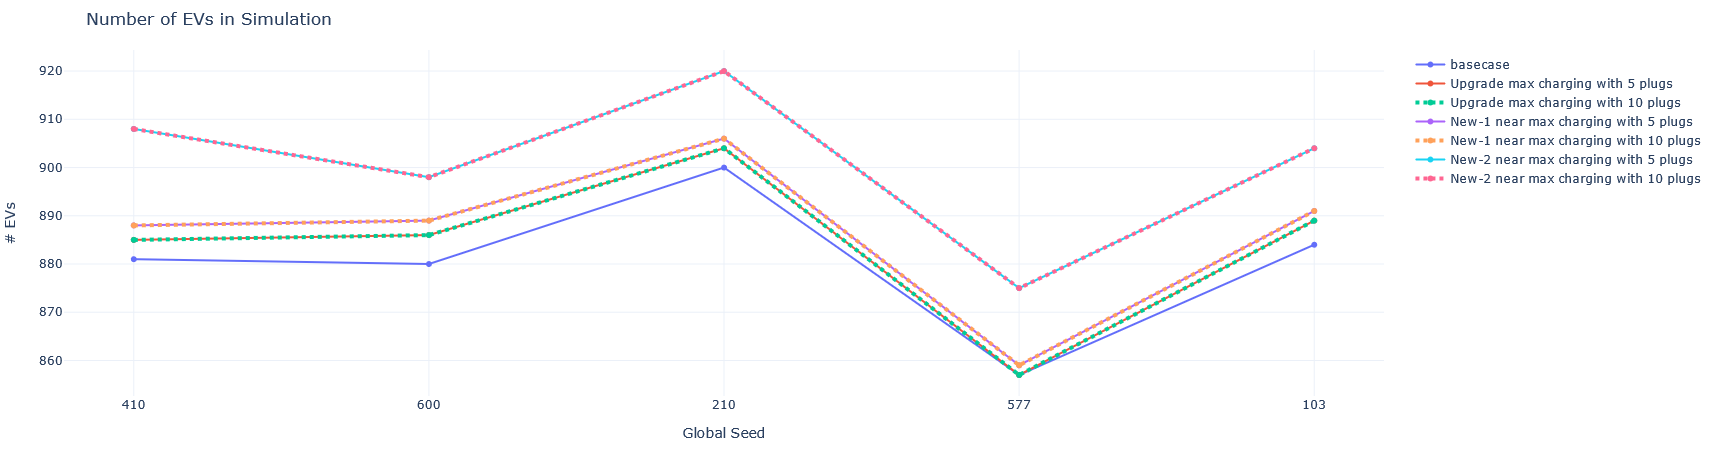

In [192]:
# EVs in simulation
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(500 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 504)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(536 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 540)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade max charging with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(541 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 545)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade max charging with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(546 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 550)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New-1 near max charging with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(551 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 555)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New-1 near max charging with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(556 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 560)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New-2 near max charging with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(561 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 565)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New-2 near max charging with 10 plugs', line=dict(width=4, dash='dot')))
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title_text = 'Number of EVs in Simulation',
        showlegend = True, yaxis_title="# EVs", 
                  xaxis_title="Global Seed", )
fig.show()

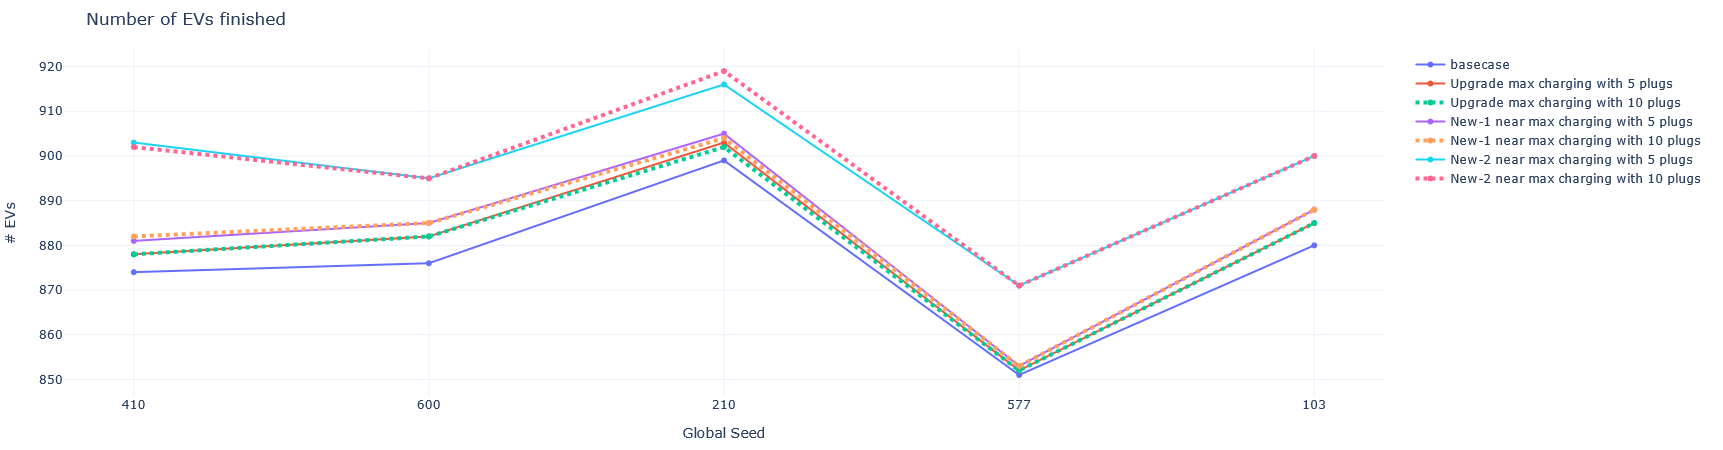

In [193]:
# EVs finished
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(500 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 504)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(536 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 540)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade max charging with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(541 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 545)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade max charging with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(546 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 550)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New-1 near max charging with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(551 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 555)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New-1 near max charging with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(556 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 560)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New-2 near max charging with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(561 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 565)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New-2 near max charging with 10 plugs', line=dict(width=4, dash='dot')))
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title_text = 'Number of EVs finished',
        showlegend = True, yaxis_title="# EVs", 
                  xaxis_title="Global Seed", )
fig.show()

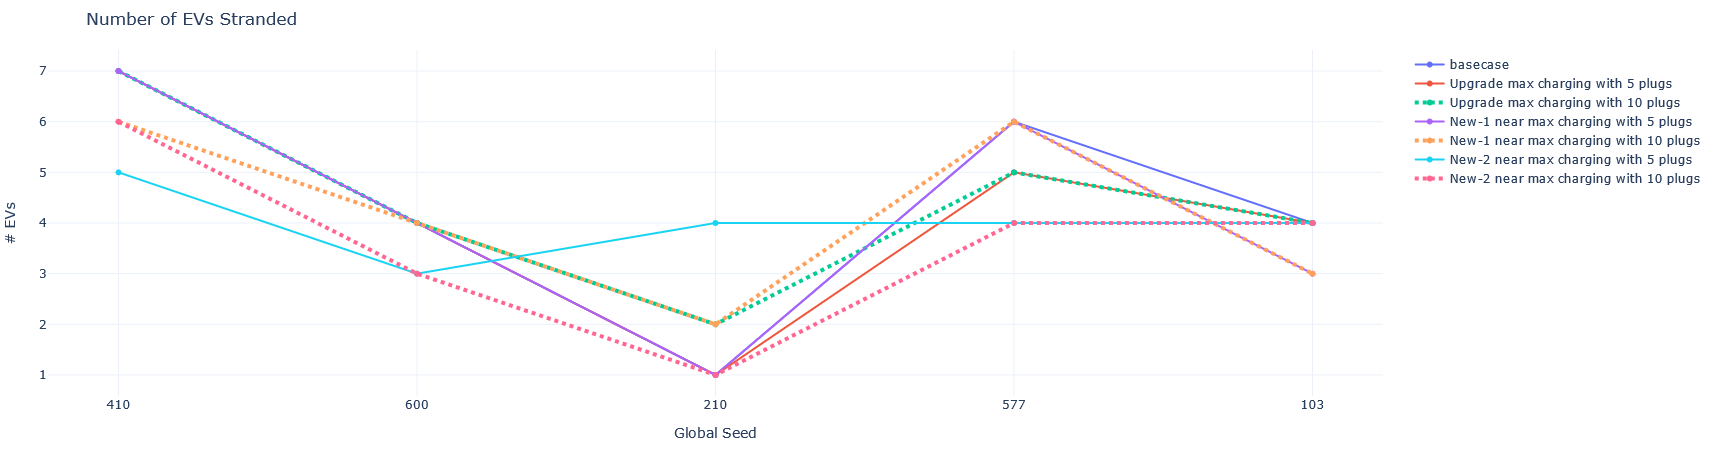

In [194]:
# EVs stranded
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(500 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 504)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(536 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 540)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade max charging with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(541 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 545)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade max charging with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(546 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 550)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New-1 near max charging with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(551 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 555)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New-1 near max charging with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(556 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 560)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New-2 near max charging with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(561 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 565)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New-2 near max charging with 10 plugs', line=dict(width=4, dash='dot')))
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title_text = 'Number of EVs Stranded',
        showlegend = True, yaxis_title="# EVs", 
                  xaxis_title="Global Seed", )
fig.show()

## 5.2 eVMT

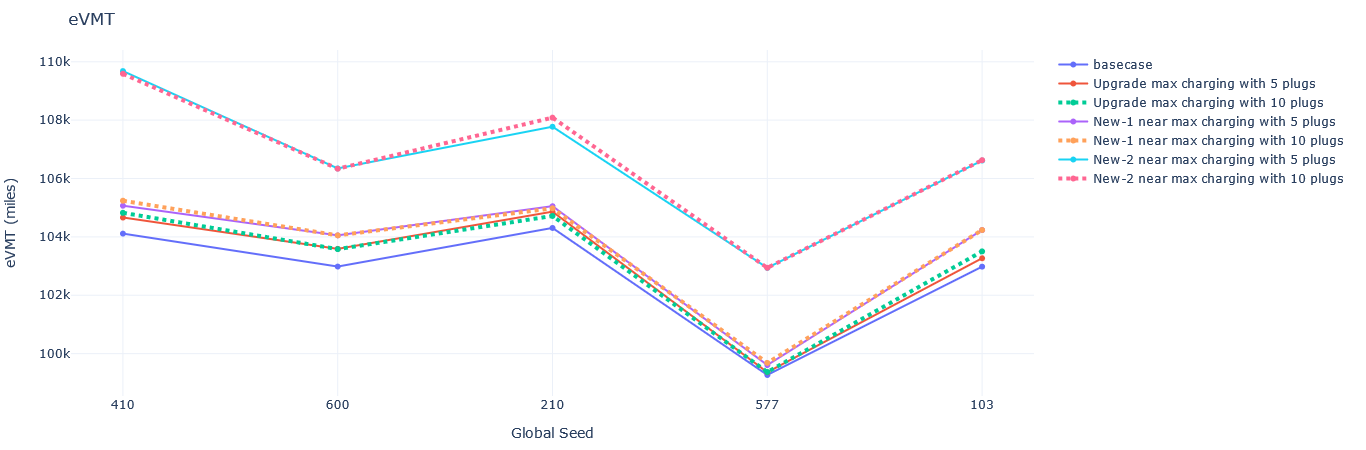

In [188]:
# evmt
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(500 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 504)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(536 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 540)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade max charging with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(541 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 545)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade max charging with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(546 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 550)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New-1 near max charging with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(551 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 555)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New-1 near max charging with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(556 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 560)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New-2 near max charging with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(561 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 565)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New-2 near max charging with 10 plugs', line=dict(width=4, dash='dot')))
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title_text = 'eVMT',
        showlegend = True, yaxis_title="eVMT (miles)", 
                  xaxis_title="Global Seed", )
fig.show()

#### 5.3 Charging and Waiting Sessions

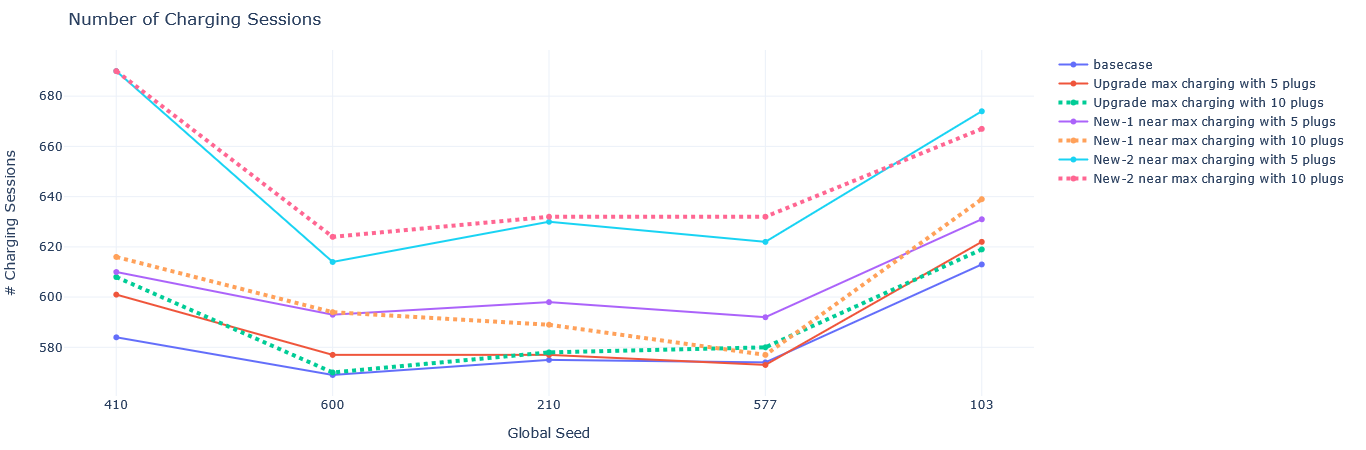

In [189]:
# charging_sessions count
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(500 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 504)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(536 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 540)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade max charging with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(541 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 545)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade max charging with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(546 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 550)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New-1 near max charging with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(551 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 555)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New-1 near max charging with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(556 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 560)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New-2 near max charging with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(561 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 565)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New-2 near max charging with 10 plugs', line=dict(width=4, dash='dot')))
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title_text = 'Number of Charging Sessions',
        showlegend = True, yaxis_title="# Charging Sessions", 
                  xaxis_title="Global Seed", )
fig.show()

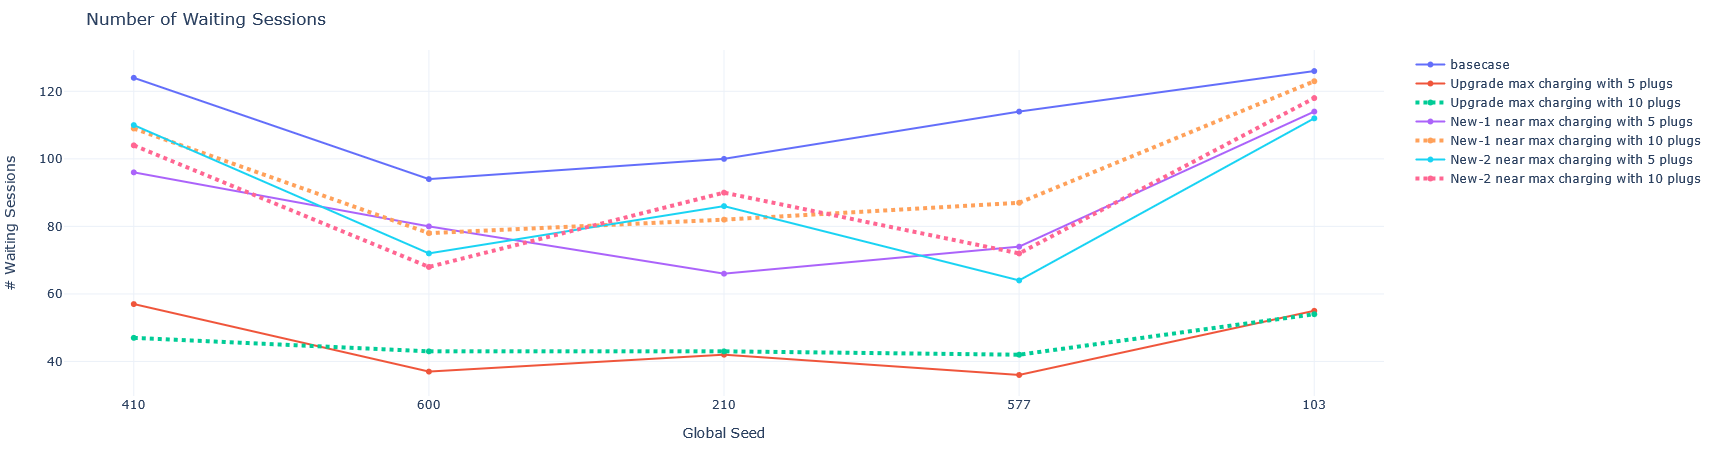

In [195]:
# waiting session count
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(500 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 504)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(536 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 540)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade max charging with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(541 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 545)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade max charging with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(546 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 550)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New-1 near max charging with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(551 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 555)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New-1 near max charging with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(556 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 560)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New-2 near max charging with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(561 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 565)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New-2 near max charging with 10 plugs', line=dict(width=4, dash='dot')))
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title_text = 'Number of Waiting Sessions',
        showlegend = True, yaxis_title="# Waiting Sessions", 
                  xaxis_title="Global Seed", )
fig.show()

In [174]:
token = os.getenv("MAPBOX_ACCESS_TOKEN")
# analysis_ids = new_evses['analysis_id'].unique()

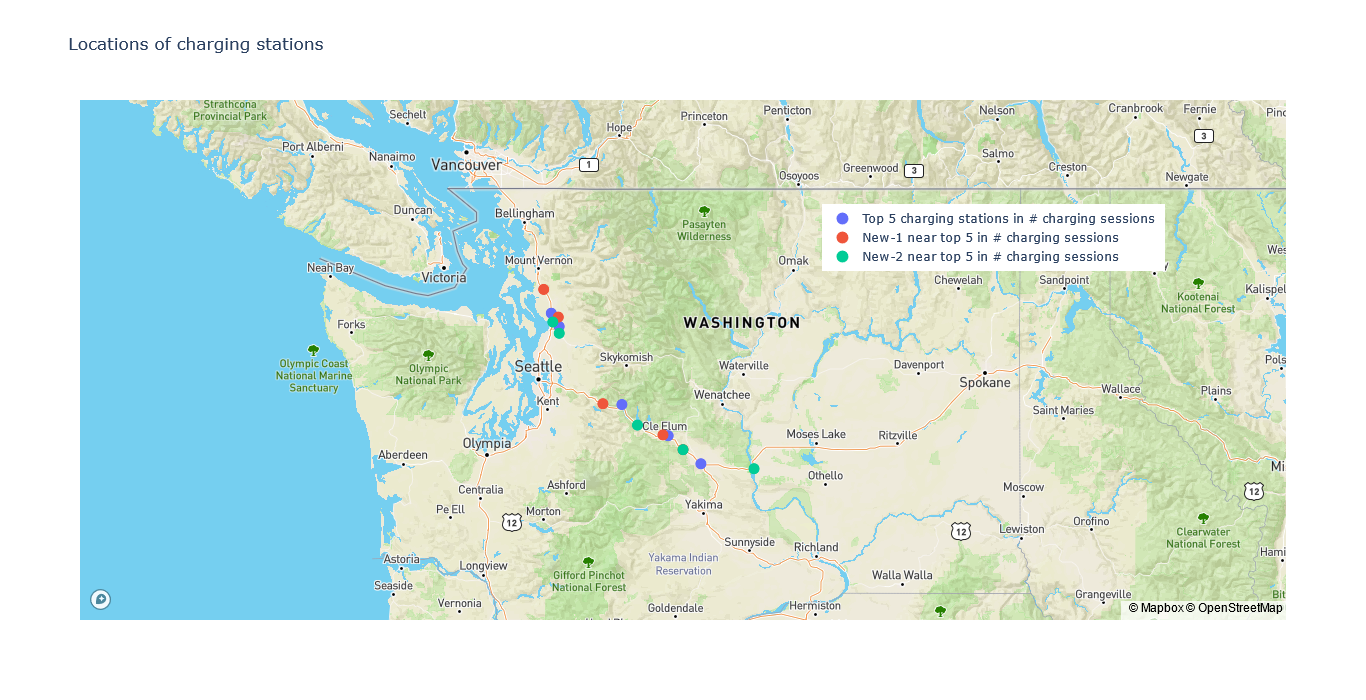

In [175]:
fig = go.Figure()
fig.add_trace(go.Scattermapbox(
        lat=be_cs['latitude'],
        lon=be_cs['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            opacity=1
        ),
        hoverinfo='none', 
    name='Top 5 charging stations in # charging sessions'
    ))
fig.add_trace(go.Scattermapbox(
        lat=ne_cs[ne_cs['analysis_id'] == 549]['latitude'],
        lon=ne_cs[ne_cs['analysis_id'] == 549]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            opacity=1
        ),
        hoverinfo='none', 
    name='New-1 near top 5 in # charging sessions'
    ))
fig.add_trace(go.Scattermapbox(
        lat=ne_cs[ne_cs['analysis_id'] == 556]['latitude'],
        lon=ne_cs[ne_cs['analysis_id'] == 556]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            opacity=1
        ),
        hoverinfo='none', 
    name='New-2 near top 5 in # charging sessions'
    ))
fig.update_layout(
        title_text = 'Locations of charging stations',
        showlegend = True,
        mapbox_style="streets", mapbox_accesstoken=token,
        mapbox_zoom=6, mapbox_center = {"lat":  47.7511, "lon": -120.7401}, 
        width=1000, 
        height=700, legend=dict(
    yanchor="top",
    y=0.8,
    xanchor="right",
    x=0.9
)
    )

fig.show()

____________
____________

Things to do the first time if the plotly plots not showing. Restart jupyter lab after. 

In [176]:
#!jupyter labextension list

In [177]:
#!jupyter labextension uninstall jupyterlab-plotly

In [178]:
#!jupyter labextension uninstall plotlywidget

In [179]:
#!export NODE_OPTIONS=--max-old-space-size=4096

In [180]:
#!pip show plotly

In [181]:
#!pip install jupyterlab "ipywidgets>=7.5"

In [182]:
#!jupyter labextension install jupyterlab-plotly@4.12.0

In [183]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.12.0

In [184]:
#!pip install "nbconvert<6"